# Product Sales Forecasting using Quantitative Methods

## Project Objective

### Goal: The goal of this project was to apply various quantitative methods, (i.e. Times Series Models and Causal Models) to forecast the sales of the products available in the dataset.

Perform time series analysis to understand the data and trends
Use multiple forecasting models on train dataset
Finally select the best model to run the test data
Models covered in the notebook include:

1).Seasonal Naive Model, 2).Holt-Winters Model (Triple Exponential Smoothing), 3).ARIMA Model and Seasonal ARIMA Models, 4).Linear Regression Model


## Import the required libraries

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

## Load Dataset
The dataset contanins historical sales records of 10 stores and 50 products, from the year 2013 through 2017.

In [2]:
df = pd.read_csv('train.csv')
df

,date,store,item,sales,f0,f1
0,01-01-2013,1,1,13.0,9.0,NaN
1,02-01-2013,1,1,11.0,NaN,NaN
2,03-01-2013,1,1,14.0,NaN,NaN
3,04-01-2013,1,1,13.0,NaN,NaN
4,05-01-2013,1,1,10.0,NaN,NaN
...,...,...,...,...,...,...
912995,27-12-2017,10,50,63.0,NaN,NaN
912996,28-12-2017,10,50,59.0,NaN,NaN
912997,29-12-2017,10,50,74.0,NaN,NaN
912998,30-12-2017,10,50,62.0,NaN,NaN


## Data cleaning
Removing the unwanted columns in the dataset.

In [3]:
df.columns

Index(['date', 'store', 'item', 'sales', 'f0', 'f1'], dtype='object')

In [4]:
df.drop(['f0', 'f1'], axis=1, inplace=True)

In [5]:
df

,date,store,item,sales
0,01-01-2013,1,1,13.0
1,02-01-2013,1,1,11.0
2,03-01-2013,1,1,14.0
3,04-01-2013,1,1,13.0
4,05-01-2013,1,1,10.0
...,...,...,...,...
912995,27-12-2017,10,50,63.0
912996,28-12-2017,10,50,59.0
912997,29-12-2017,10,50,74.0
912998,30-12-2017,10,50,62.0


## Checking basic details of dataset
Like shape, data type, describe

In [6]:
df.shape

(913000, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    913000 non-null  object 
 1   store   913000 non-null  int64  
 2   item    913000 non-null  int64  
 3   sales   912943 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 27.9+ MB


In [8]:
#change data type for date column
df['date'] = df['date'].astype('datetime64[ns]')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   912943 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 27.9 MB


In [10]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,912943.000000
mean,5.500000,25.500000,52.251626
std,2.872283,14.430878,28.801046
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


## Missing Values Imputation
Check for the missing values in the dataset.

In [11]:
df.isnull().sum()

date      0
store     0
item      0
sales    57
dtype: int64

## Filling the missing values
Using interpolation method to fill the missing values in the dataset.

In [12]:
df = df.set_index('date')
df = df.interpolate() # can add different methods to fill the missing values

In [13]:
df = df.reset_index(drop=False) 
df


,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-02-01,1,1,11.0
2,2013-03-01,1,1,14.0
3,2013-04-01,1,1,13.0
4,2013-05-01,1,1,10.0
...,...,...,...,...
912995,2017-12-27,10,50,63.0
912996,2017-12-28,10,50,59.0
912997,2017-12-29,10,50,74.0
912998,2017-12-30,10,50,62.0


In [14]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

## Data Preprocessing
For the purpose of this project, we will only look at the sales of 'item' - 1 from 'store' - 1. The dataset is split into train and test sets, where the train set contains sales record from January 2013 to September 2017 and the test set (validation set) contains sales records of the last three month of 2017.

Some new features have been created from the date field, for the purpose of exploratory data analysis and causal modelling.

In [15]:
# sort values based on date column
df.sort_values(by='date', ascending = True, inplace = True) 

In [16]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
df = df[df['store'] == 1]
df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)                         
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13.0,2013,1,1,1
1,2013-01-02,1,1,11.0,2013,1,2,2
2,2013-01-03,1,1,15.0,2013,1,3,3
3,2013-01-04,1,1,11.0,2013,1,4,4
4,2013-01-05,1,1,16.0,2013,1,5,5


In [17]:
test_df.head()

,date,store,item,sales,year,month,day,weekday
0,2017-10-01,1,1,11.0,2017,10,1,6
1,2017-10-02,1,1,16.0,2017,10,2,7
2,2017-10-03,1,1,18.0,2017,10,3,1
3,2017-10-04,1,1,19.0,2017,10,4,2
4,2017-10-05,1,1,17.0,2017,10,5,3


## Data Exploration
The plots below try to capture the trend and distribution of sales through weeks, months and years.

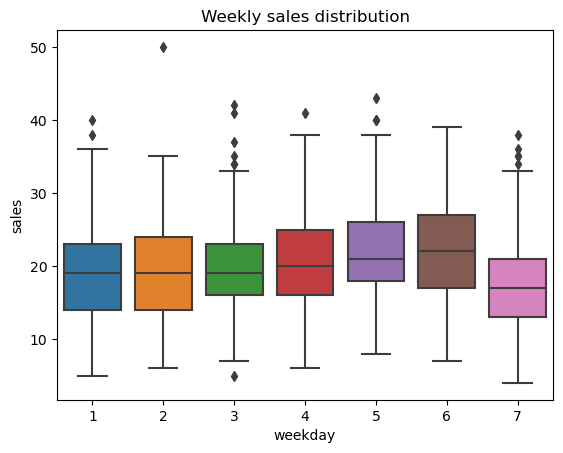

In [18]:
plot = sns.boxplot(x='weekday', y='sales', data=df)
_ = plot.set(title='Weekly sales distribution')

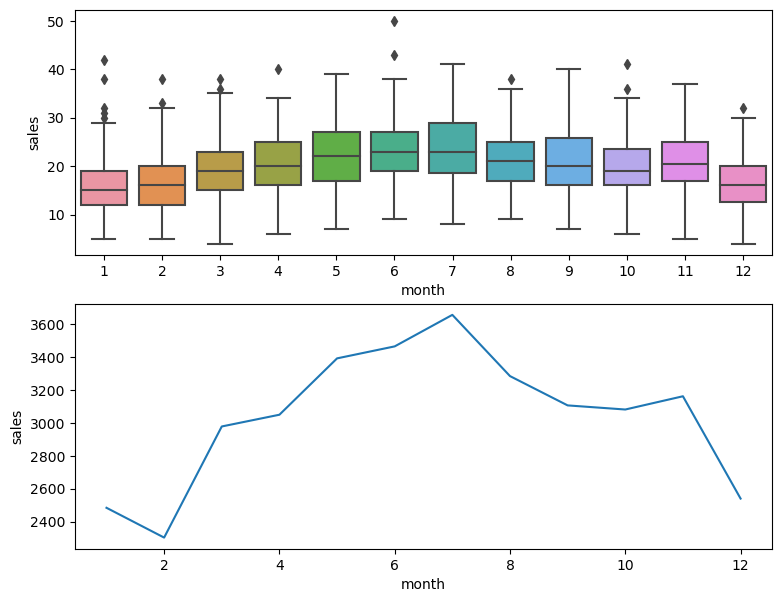

In [19]:
monthly_agg = df.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sns.boxplot(x='month', y='sales', data=df, ax=axs[0])
_ = sns.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])

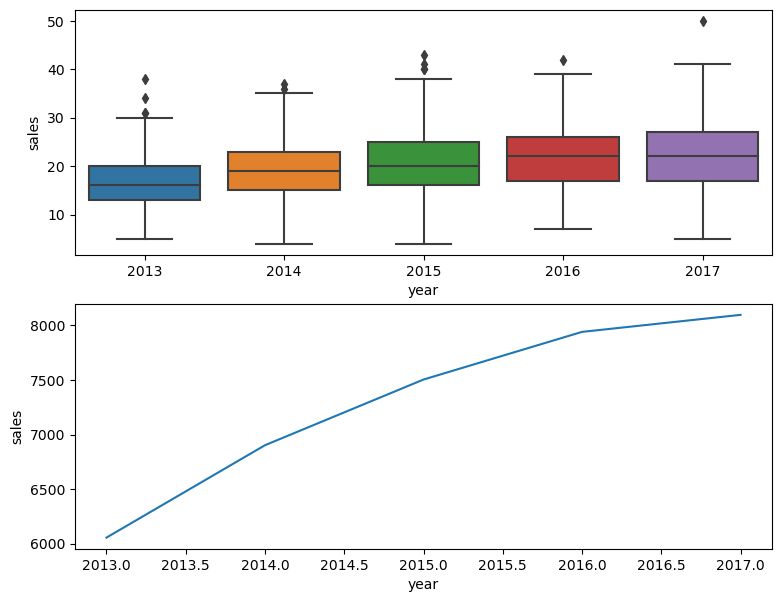

In [20]:
yearly_agg = df.groupby('year')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sns.boxplot(x='year', y='sales', data=df, ax=axs[0])
_ = sns.lineplot(x='year', y='sales', data=yearly_agg, ax=axs[1])

**Inference**: From the number of sales vs. year plot, we can infer an increasing trend over the years. The aggregate number of sales has increased from approximately 6000 in 2013 to slightly over 8000 in 2017, i.e. a 33.3% increase in the number of sales approximately. A clear trend is captured by the lineplot above.

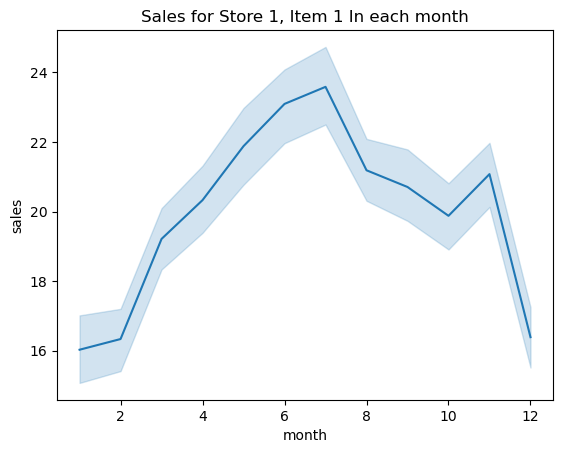

In [21]:
plot = sns.lineplot(x='month', y='sales', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 In each month')

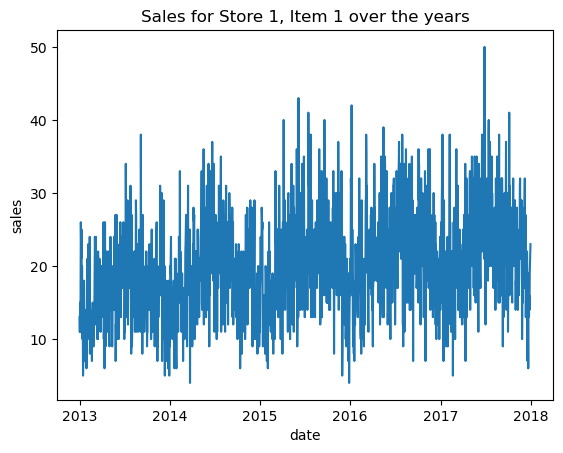

In [22]:
plot = sns.lineplot(x='date', y='sales', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')

**Inference**: There is a seasonal pattern in the number of sales of 'item' - 1 at 'store' - 1. As also infered in the plot for sales vs. month above, we can see an increase in the sales in the first half of the year, peaking in July, and then a gradual decrease till December. This pattern is repeated each year, 2013 onwards.

## Time Series Decomposition Plot
A time series decomposition plot allows us to observe the seasonality, trend, and error/remainder terms of a time series. These three components are a crucial part of the Exponential Smoothing models. Therfore, the decomposition plot helps in deciding the type of Exponential Smoothing Model to use for our forecasts.


In [23]:
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['sales'] = ts_decomp_df['sales'].astype(float)
ts_decomp_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,15.0,2013,1,3,3
2013-01-04,1,1,11.0,2013,1,4,4
2013-01-05,1,1,16.0,2013,1,5,5


<Figure size 640x480 with 0 Axes>

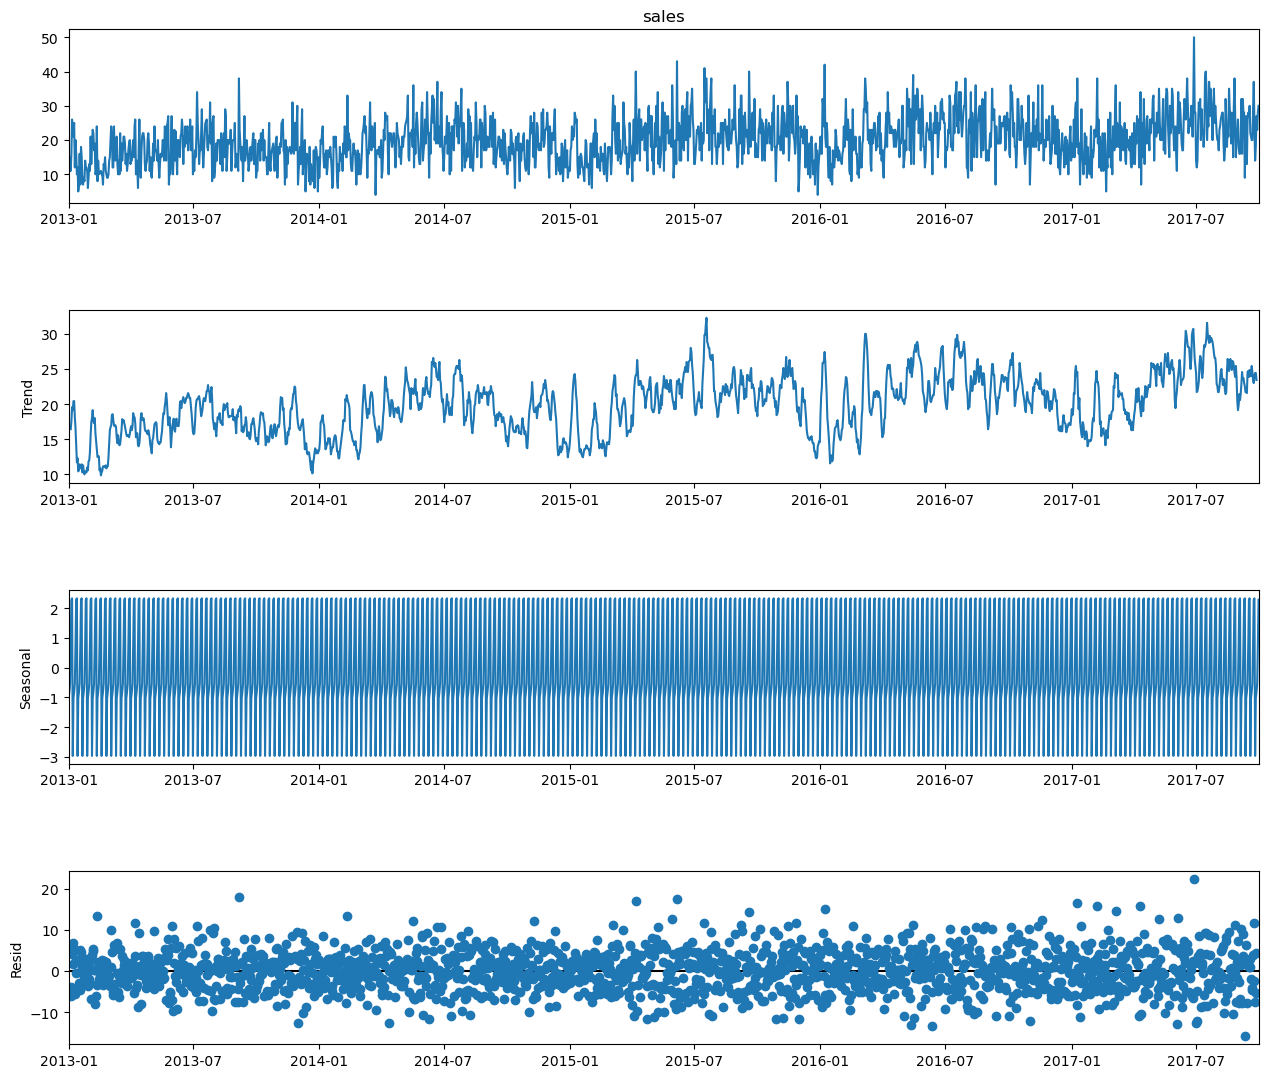

In [24]:
# Infer the frequency of the data
result = seasonal_decompose(ts_decomp_df['sales'], model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

## Determine Error, Trend and Seasonality
An ETS model has three main components: error, trend, and seasonality. Each can be applied either additively, multiplicatively, or not at all. We will use the above Times Series Decomposition Plot to determine the additive or multiplicative property of the thre components.

Trend - If the trend plot is linear then we apply it additively (A). If the trend line grows or shrinks exponentially, we apply it multiplicatively (M). If there is no clear trend, no trend component is included (N).

Seasonal - If the peaks and valleys for seasonality are constant over time, we apply it additively (A). If the size of the seasonal fluctuations tends to increase or decrease with the level of time series, we apply it multiplicatively (M). If there is no seasonality, it is not applied (N).

Error - If the error plot has constant variance over time (peaks and valleys are about the same size), we apply it additively (A). If the error plot is fluctuating between large and small errors over time, we apply it multiplicatively (M).

**For our sales data, we see a linear trend plot and a constant seasonality over time, so we will apply trend and seasonality additively. The error component also has constant variance, so we will apply it additively too.**



## Quantitative Methods to Forecast Product Sales
It can be fairly concluded from the data exploratory plots above that there is seasonality present in the product sales data, along with a general increase in the number of sales over the years. Therefore, in order to forecast the number of sales for the last three months of 2017, we will keep in mind the linear trend and seasonality present in the product sales.
There are multiple ways to approach the forecasting problem, we can either build traditional time series models, or use causal models, such as linear regression. We will look at both these methods and try to evaluate our forecasts using the validation set.

1).**Seasonal Naive Model:**
    Suitability: Seasonal Naive is appropriate when your data has a strong seasonal pattern, but it assumes no trend. If your data exhibits a clear seasonal component with no underlying trend, this simple model can be effective.

2).**Holt-Winters Model (Triple Exponential Smoothing):**
    Suitability: Holt-Winters is suitable for data with both trend and seasonality. It extends the exponential smoothing model to handle both trends and seasonality, making it a good choice when your time series data exhibits these patterns.
    
3).**ARIMA Model and Seasonal ARIMA Models:**
    Suitability: ARIMA models are effective for data with a clear trend but may struggle with seasonality. Seasonal ARIMA models (SARIMA) extend ARIMA to handle seasonality as well. If your data shows both trend and seasonality, SARIMA is a more appropriate choice.
    
4).**Linear Regression with additional features:**
        which is common techniques for creating additional features to capture trends and seasonality

## 1. Baseline Model: Seasonal Naive
Before we get to the more advanced time-series forecasting methods, let's take a look at a basic method - Seasonal Naive. It can serve as a quick calculation to get a baseline until something better can come along. Or, perhaps there is very little variance in the data, then this method can be good enough.

### What is Seasonal Naive?

It is a naive method that takes the seasonal patterns into account by looking at what happened same time last year. For example, if we want to predict the sales during December 2017, the seasonal naive method will assume the same number of sales for December 2017 as was in December 2016. Fortunately, we have at least one-year of sales data, this method might make no sense otherwise.

In the code below, one year is subtracted from the dates in the test data, and one day is added to the resulting difference, after which they are looked up in the training data to return the sales from those respective dates. So keeping the seasonality in mind, we now have our naive forecasts based on the number of sales from a year ago.

In [25]:
# subtract 1 year from test data
dates = (test_df['date'] - np.timedelta64(1, 'Y') + \
        np.timedelta64(1, 'D')).values.astype('datetime64[D]') 
seasonal_naive_sales = train_df[train_df['date'].astype('datetime64[D]').isin(dates)]['sales'] 

# make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('sales', axis=1)
sn_pred_df['seasonal_naive_sales'] = pd.DataFrame(seasonal_naive_sales).set_index(test_df.index)
sn_pred_df.head()

,date,store,item,year,month,day,weekday,seasonal_naive_sales
0,2017-10-01,1,1,2017,10,1,6,26.0
1,2017-10-02,1,1,2017,10,2,7,16.0
2,2017-10-03,1,1,2017,10,3,1,15.0
3,2017-10-04,1,1,2017,10,4,2,36.0
4,2017-10-05,1,1,2017,10,5,3,29.0


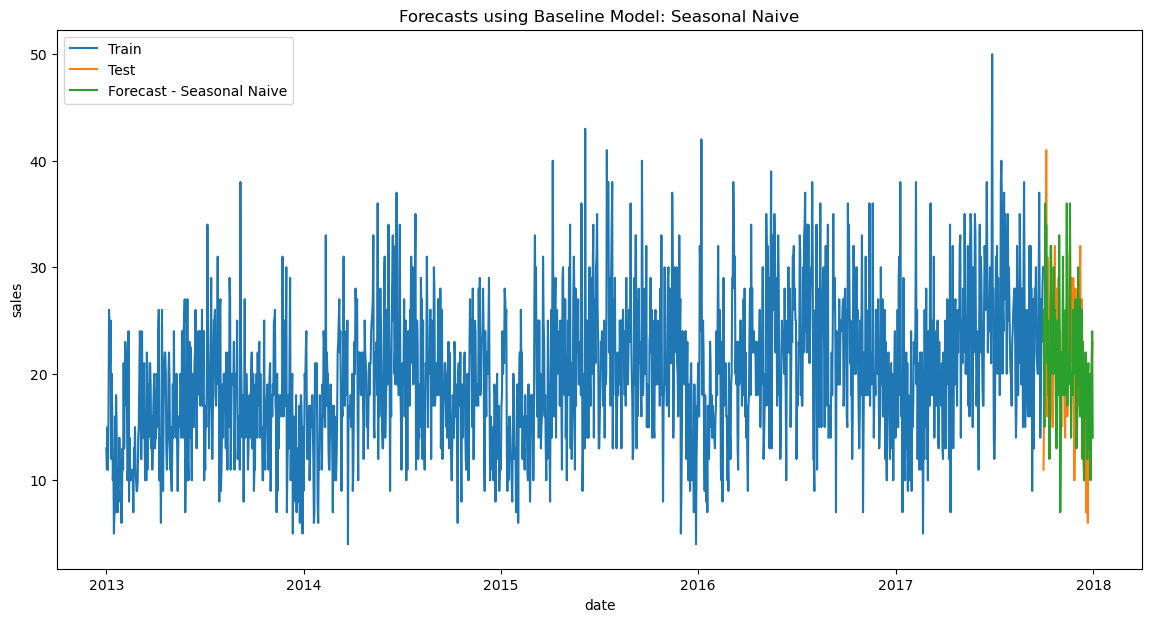

In [26]:
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.show()

**Inference:** To the naked eye, the forecasts seem alright the decreasing trend is clearly captured by our naive method. However, we will formally quantify the performance using forecast accuracy metrics.

Evaluating the Forecasts

There are number of widely accepted forecasting metrics, and the most common metric is forecast error. The error can simply be calculated by finding the diffrence between the actual sales value and the forecasted sales value. For example, if 10 items are sold on a day, and you predicted 14 items to be sold, you have an error of -4.

In order to evaluate the overall forecast, we will look at metrics like mean absolute error (MAE), root mean squared error (RMSE) and a percentage error metric - mean absolute percentage error (MAPE).

**MAE**: It is the absolute value of the error, summed for each observed day, and divided by the total number of observed days.

**RMSE**: It is similar to MAE, however rather than the absolute value, the error is squared before it is summed, and then the square root is taken to normalize the units. Because we take the square of the error, we wind up punishing large forecasting errors more than small ones.

The above two metrics are scale-dependent meaning that we cannot use them to compare forecasts on different scales. MAPE on the other hand is a scale-independent metric.

**MAPE**: It can be used for meaningful comparisions, it is calculated by dividing the sum of absolute errors by sum of actual sales to get a percentage indicator that is scaled to the actual sales.
Let's apply the above metrics to our forecasts and see how they compare.

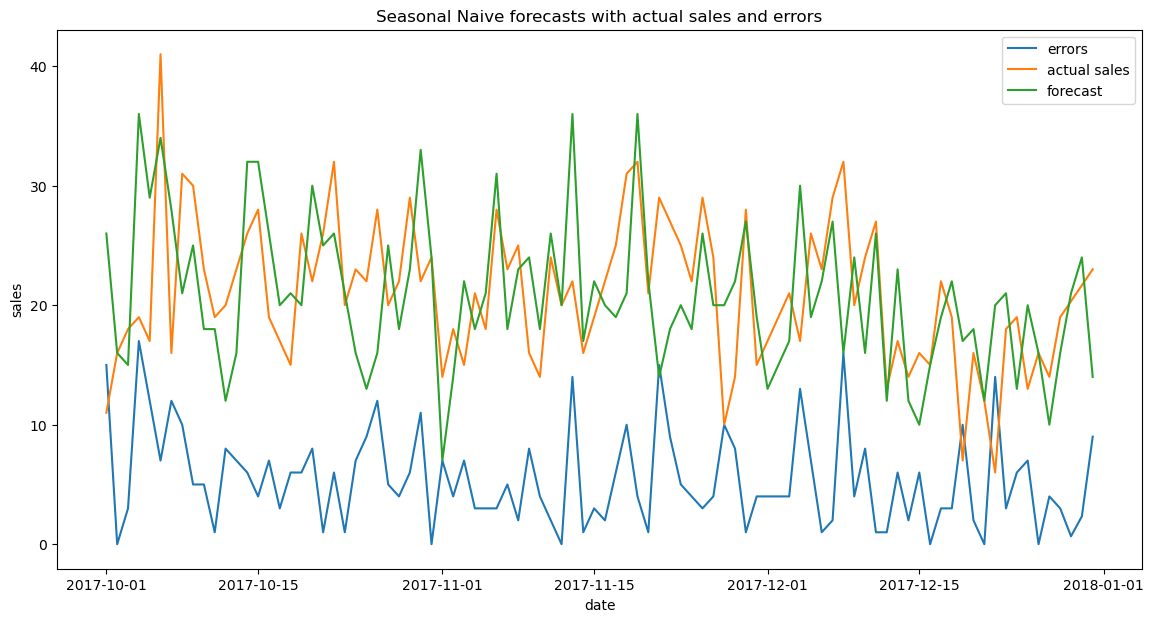

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,1928.0,1914.0,14.0,5.456522,6.803842,26.037344


In [27]:
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df['errors'] = test_df['sales'] - sn_pred_df['seasonal_naive_sales']
errors_df.insert(0, 'model', 'Seasonal Naive') 

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

result_df = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                           total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae), 
                                           RMSE=('errors', rmse), 
                                           MAPE=('errors', mape))
    

plt.figure(figsize=(14,7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['sales'], label='actual sales')
plt.plot(errors_df['date'], errors_df['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.show()

result_df

The overall error is not as bad, and we were able to achieve a MAPE of 26.03%. We will use this as a benchmark to judge the forecast performance of the other models. Let's move on to a more advanced model that uses Exponential Smoothing, but before that let's take a look at the time series decomposition plot for our training data.

We will use a Exponential Smoothing, a commonly-used local statistical algorithm for time-series forecasting. The Exponential Smoothing method can be defined in terms of an ETS framework, in which the components are calculated using a smoothing technique.

## What is Exponential Smoothing?
This is a very popular scheme to produce a smoothed Time Series. Whereas in Single Moving Averages the past observations are weighted equally, Exponential Smoothing assigns exponentially decreasing weights as the observation get older. In other words, recent observations are given relatively more weight in forecasting than the older observations.
In the case of moving averages, the weights assigned to the observations are the same and are equal to 1/N. In exponential smoothing, however, there are one or more smoothing parameters to be determined (or estimated) and these choices determine the weights assigned to the observations.

There are 3 kinds of smoothing techniques Single, Double and Triple Exponential Smoothing.

**Single Exponential Smoothing** is used when the time series does not have a trend line and a seasonality component.
**Double Exponential Smoothing** is used to include forecasting data with a trend, smoothing calculation includes one for the level, and one for the trend.
**Triple Exponential smoothing** is used when data has trend and seasonality. We include a third equation to take care of seasonality (sometimes called periodicity). The resulting set of equations is called the "Holt-Winters" (HW) method after the names of the inventors.
Since out data has both trend and seasonality components, we will apply Triple Exponential Smoothing.

## 2. Holt Winter's Triple Exponential Smoothing Model


In [28]:
hw_train_df = train_df[['date', 'sales']].set_index('date')
hw_test_df = test_df[['date', 'sales']].set_index('date')

# Apply Triple Exponential Smoothing

hw_model_1 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12)
hw_fit_1 = hw_model_1.fit(remove_bias=False)
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]), 
                       name='pred_sales').reset_index()

hw_model_2 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12, damped=True)
hw_fit_2 = hw_model_2.fit(remove_bias=False)
pred_fit_2 = pd.Series(hw_fit_2.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]), 
                       name='pred_sales').reset_index()
print('Forecasts made, ready for evaluation')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Forecasts made, ready for evaluation


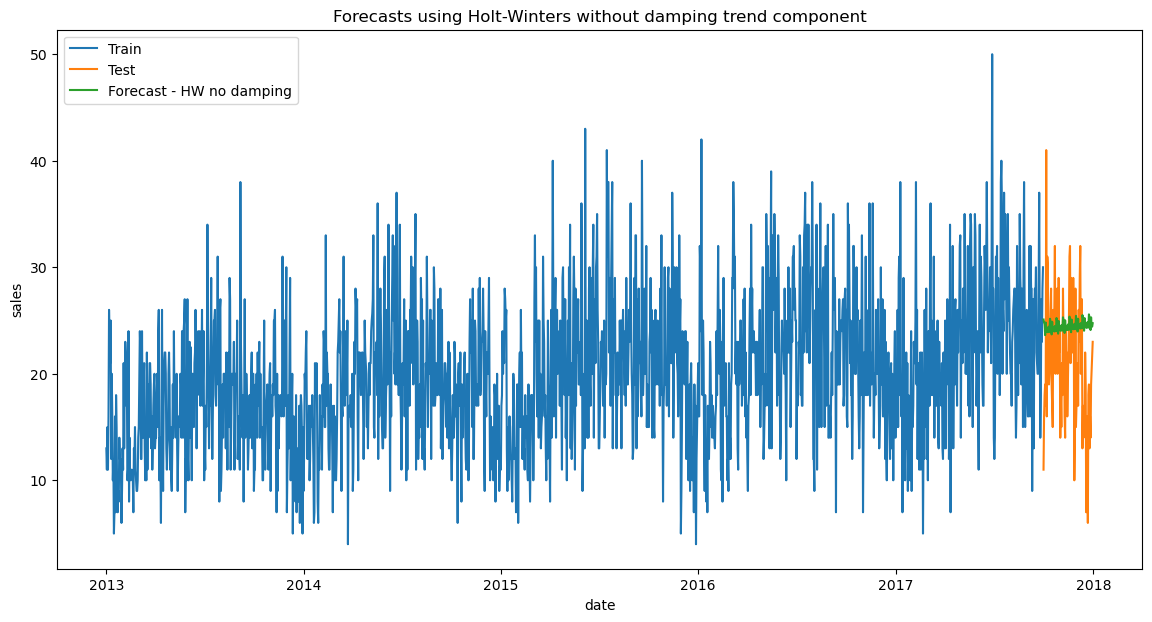

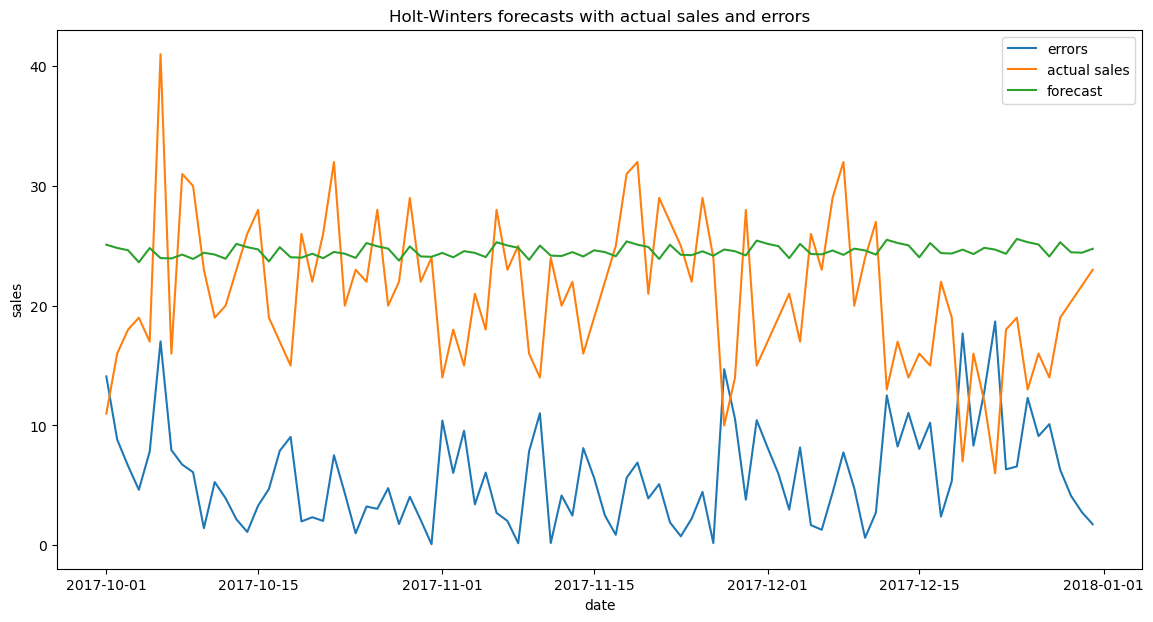

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters,1928.0,2258.27907,-330.27907,5.800869,7.112739,27.680493


In [29]:
# Merge predictions and actual sales into one df
errors_df_hw = pd.merge(test_df, pred_fit_1, left_on='date', right_on='index')
errors_df_hw = errors_df_hw[['date', 'sales', 'pred_sales']]
errors_df_hw['errors'] = errors_df_hw.sales - errors_df_hw.pred_sales
errors_df_hw.insert(0, 'model', 'Holt-Winters')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='Forecast - HW no damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters without damping trend component')
plt.show()


plt.figure(figsize=(14,7))
plt.plot(errors_df_hw['date'], np.abs(errors_df_hw['errors']), label='errors')
plt.plot(errors_df_hw['date'], errors_df_hw['sales'], label='actual sales')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters forecasts with actual sales and errors')
plt.show()

result_df_hw = errors_df_hw.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_hw

**Inference:** The decreasing trend is clearly captured by the Holt-Winters method, and the MAPE 27.6% is better in comparision to our baseline model. Let's try Holt-Winters method with a damped parameter, and see if we can improve the results

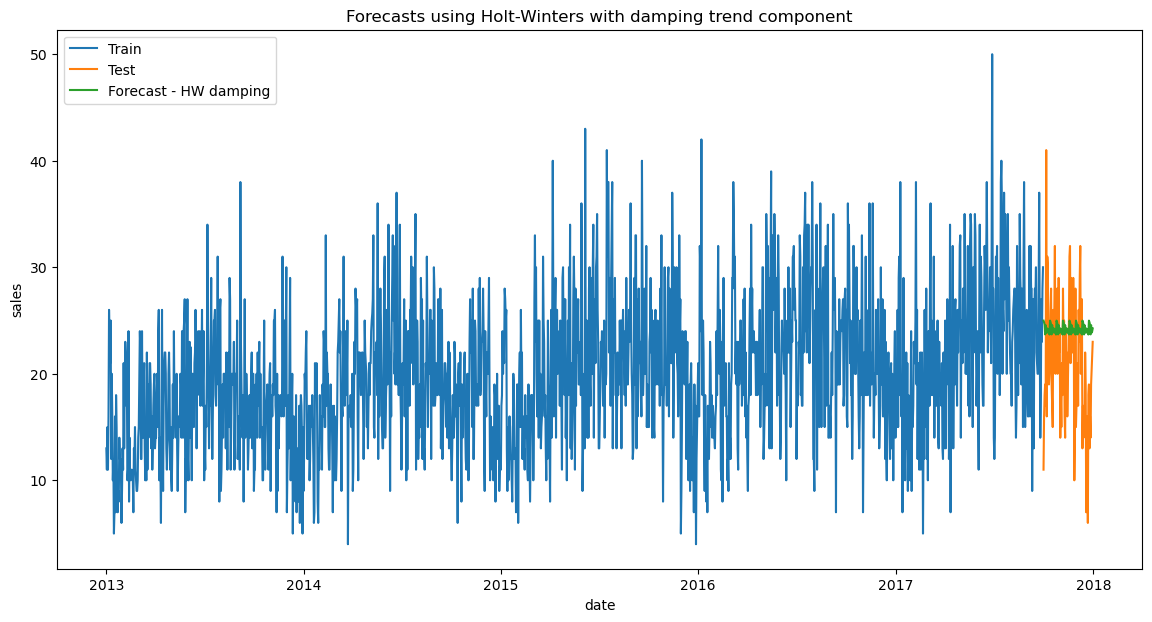

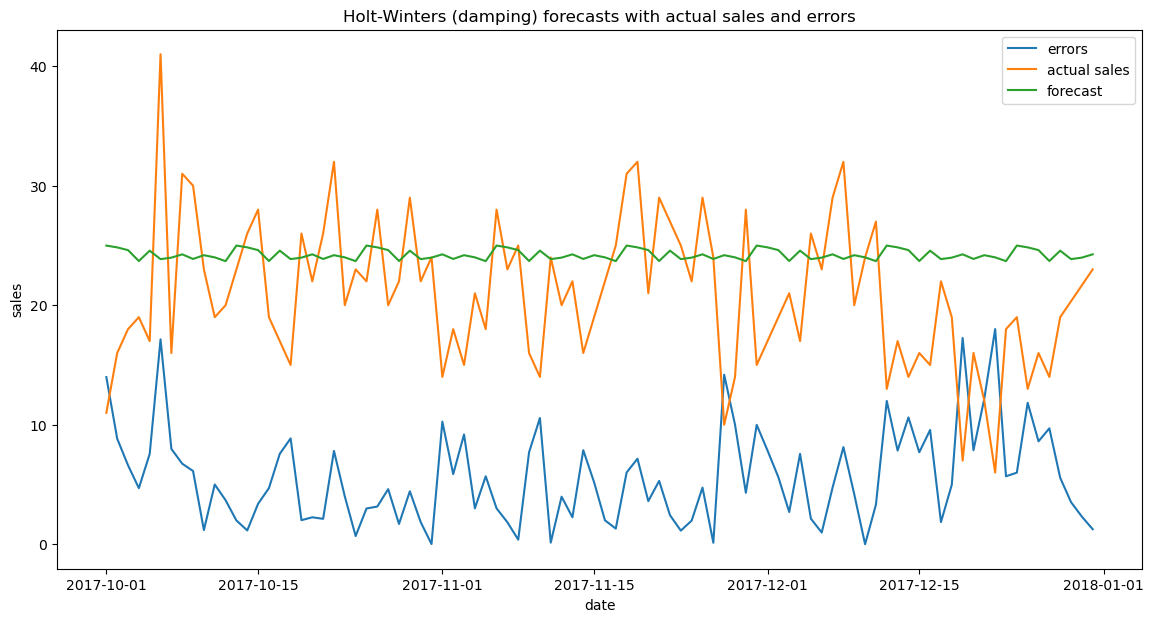

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters-Damped,1928.0,2228.726198,-300.726198,5.628096,6.909968,26.856059


In [30]:
# Merge predictions and actual sales into one df
errors_df_hwd = pd.merge(test_df, pred_fit_2, left_on='date', right_on='index')
errors_df_hwd = errors_df_hwd[['date', 'sales','pred_sales']]
errors_df_hwd['errors'] = errors_df_hwd.sales - errors_df_hwd.pred_sales
errors_df_hwd.insert(0, 'model', 'Holt-Winters-Damped') 


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='Forecast - HW damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters with damping trend component')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(errors_df_hwd['date'], np.abs(errors_df_hwd['errors']), label='errors')
plt.plot(errors_df_hwd['date'], errors_df_hwd['sales'], label='actual sales')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters (damping) forecasts with actual sales and errors')
plt.show()

result_df_hwd = errors_df_hwd.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_hwd

**Inference:** To the naked eye, the forecasts seem alright, however the MAPE 26.8% is worse than our baseline model.

Let's look at another popular time-series method: Autoregressive Integrated Moving Average (ARIMA) Model.

## 3. Autoregressive Integrated Moving Average - ARIMA Model
Trend Elements There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:

p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order.
Note: ARIMA model doesn't have the seasonal element (it's in SARIMA)

### Step 1: Check stationarity
Before going any further into our analysis, our series has to be made stationary.

Stationarity is the property of exhibiting constant statistical properties (mean, variance, autocorrelation, etc.). If the mean of a time-series increases over time, then it’s not stationary.

The mean across many time periods is only informative if the expected value is the same across those time periods. If these population parameters can vary, what are we really estimating by taking an average across time?

Stationarity requires that the statistical properties must be the same across time, making the sample average a reasonable way to estimate them.

**Methods to Check Stationarity**

**Plotting rolling statistics:** Plotting rolling means and variances is a first good way to visually inspect our series. If the rolling statistics exhibit a clear trend (upwards or downwards) and show varying variance (increasing or decreasing amplitude), then you might conclude that the series is very likely not to be stationary.

**Augmented Dickey-Fuller Test:** This test is used to assess whether or not a time-series is stationary. It gives a result called a “test-statistic”, based on which you can say, with different levels (or percentage) of confidence, if the time-series is stationary or not. The test statistic is expected to be negative; therefore, it has to be more negative(less) than the critical value for the hypothesis to be rejected and conclude that series is stationary.

ACF and PACF plots: An autocorrelation (ACF) plot represents the autocorrelation of the series with lags of itself. A partial autocorrelation (PACF) plot represents the amount of correlation between a series and a lag of itself that is not explained by correlations at all lower-order lags.

Ideally, we want no correlation between the series and lags of itself. Graphically speaking, we would like all the spikes to fall in the blue region.

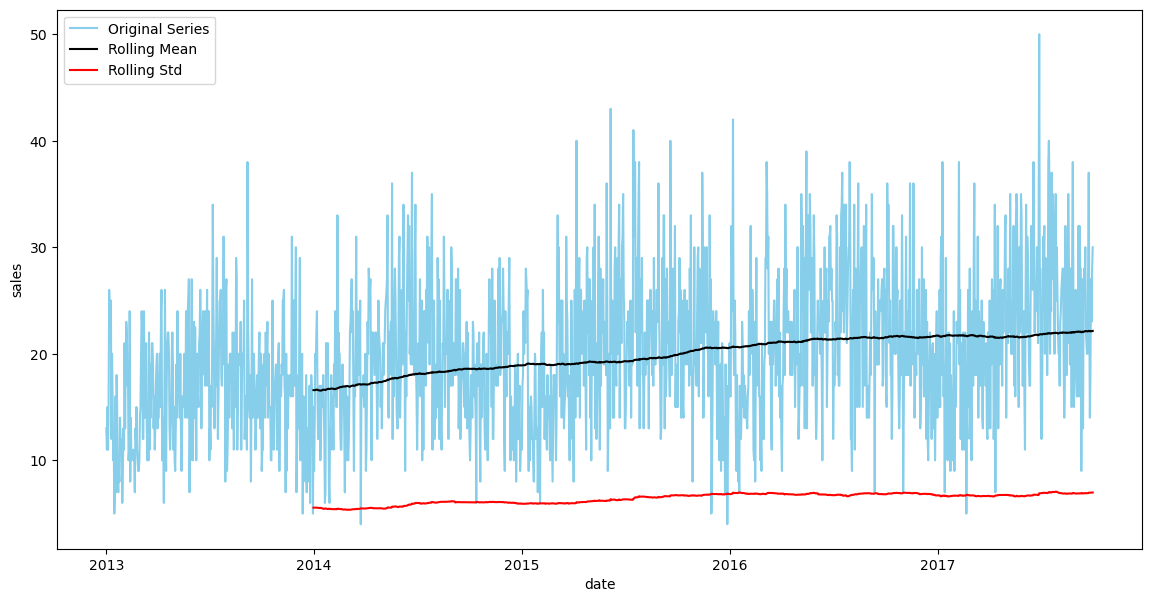

Test statistic = -4.640
P-value = 0.000
Critical values :
	1%: -3.434177666727206 - The data is  stationary with 99% confidence
	5%: -2.8632307003234203 - The data is  stationary with 95% confidence
	10%: -2.5676700828345895 - The data is  stationary with 90% confidence


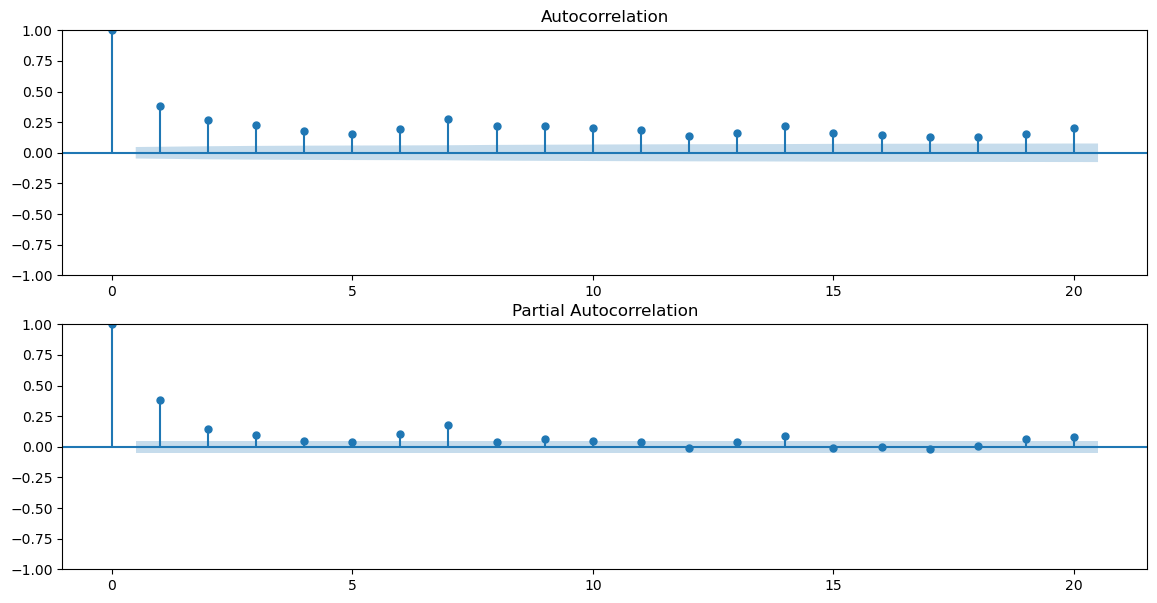

In [31]:
arima_df = train_df[['date', 'sales']].set_index('date')
arima_test_df = test_df[['date', 'sales']].set_index('date')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()
    
    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")
    
    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))
        
    # Autocorrelation Plots
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)
    
test_stationarity(arima_df.sales)

Looking at the results from our test, we can conclude that the series is not stationary. Therefore, in order to make the series stationary we apply Differencing

Step 2: Differencing
Differencing: Seasonal or cyclical patterns can be removed by substracting periodical values. If the data is 12-month seasonal, substracting the series with a 12-lag difference series will give a “flatter” series. Since we have aggregated the data to each day-level, we will shift by 1.

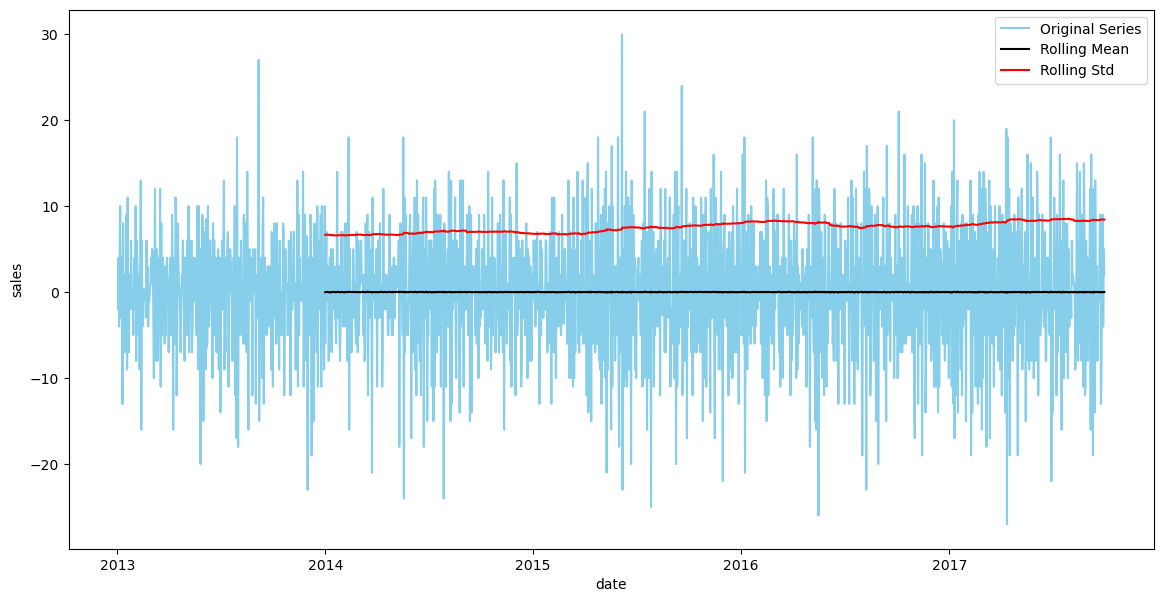

Test statistic = -13.661
P-value = 0.000
Critical values :
	1%: -3.4341866496114535 - The data is  stationary with 99% confidence
	5%: -2.8632346655630943 - The data is  stationary with 95% confidence
	10%: -2.567672194245481 - The data is  stationary with 90% confidence


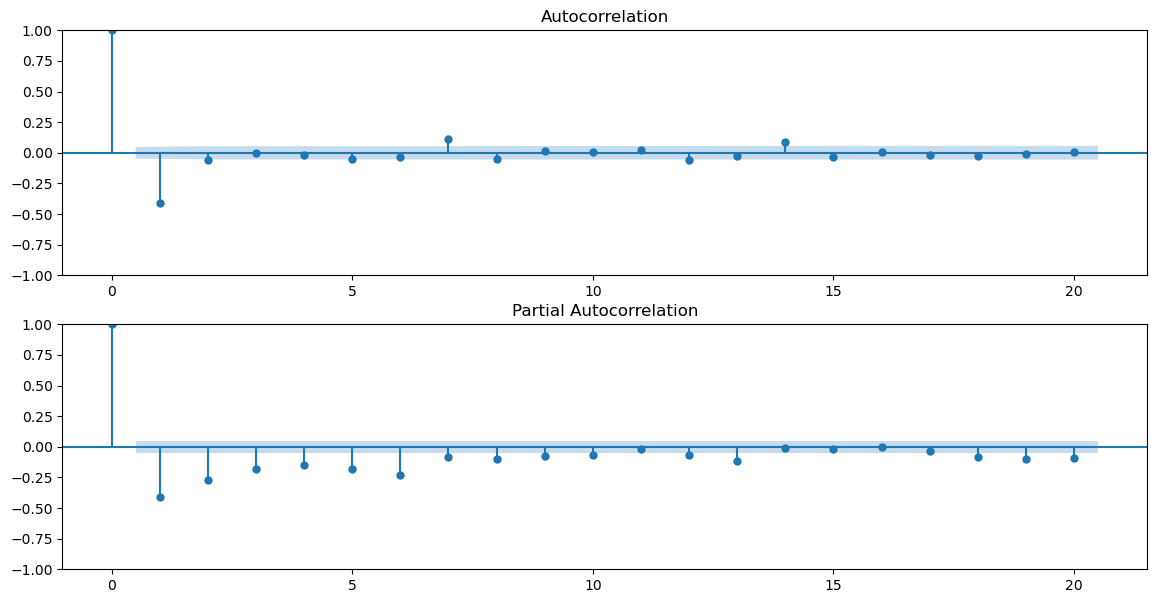

In [32]:
first_difference = arima_df.sales - arima_df.sales.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
# Check for stationarity after differencing
test_stationarity(first_difference.sales)

After applying Differencing to the series, we can see from the above results that the series is now stationary, i.e. mean and variance are constant over time, and from ADF we can verify that the test-statistic is lesser than the critical value, hence we can reject the null hypothesis and conclude that the series is staionary.

**Step 3: Model Building**
Interpreting the AR(p), I(d), MA(q) values:
Determining I(d):

Taking the first order difference makes the time series stationary. Therefore, I(d) = 1.

**Determining AR(p):** If the lag-1 autocorrelation of the differenced series PACF is negative, and/or there is a sharp cutoff, then choose a AR order of 1.

From the PACF plot we can clearly observe that within 6 lags the AR is significant. Therefore, we can use AR(p) = 6, (6 lines are crossed the blue lines so 6past days are required to predict).

**Determining MA(q):** If the lag-1 autocorrelation of the differenced series ACF is negative, and/or there is a sharp cutoff, then choose a MA order of 1.

From tha ACF plot we see a negative spike at lag 1, therfore we can use MA(q) = 1

In [33]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(arima_df['sales'], order=(6, 1, 1))
arima_fit = arima_model.fit()

print(arima_fit.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1734
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -5556.476
Date:                Sat, 03 Feb 2024   AIC                          11128.951
Time:                        01:27:12   BIC                          11172.612
Sample:                    01-01-2013   HQIC                         11145.099
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2058      0.025      8.125      0.000       0.156       0.255
ar.L2          0.0293      0.025      1.180      0.238      -0.019       0.078
ar.L3          0.0077      0.025      0.312      0.7

### Plotting the residuals using ACF and PACF
Plotting the residuals shows that recurring correlation exists in both ACF and PACF. So we need to deal with seasonality. When the plots of ACF and PACF are similar or any sesaonality is present between them then, we need to apply the Seasonal ARIMA (SARIMA) model.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


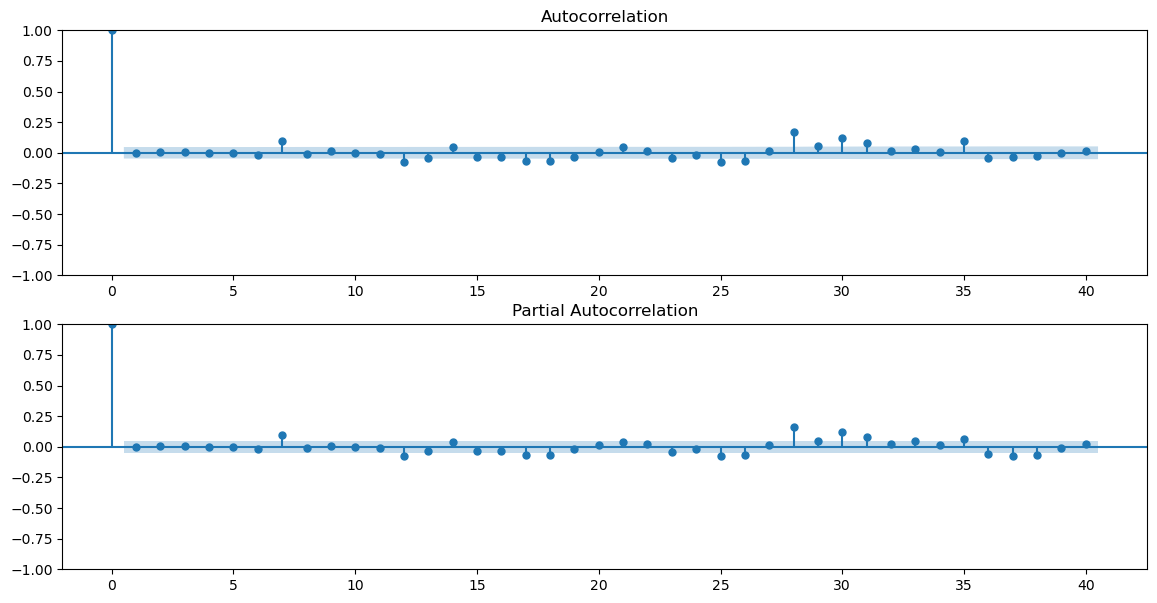

In [34]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

arima_model = ARIMA(arima_df['sales'], order=(6, 1, 1))
arima_fit = arima_model.fit()

residuals = arima_fit.resid

# Checking for seasonality
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0] = plot_acf(residuals, ax=ax[0], lags=40)
ax[1] = plot_pacf(residuals, ax=ax[1], lags=40)

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

SARIMA is Seasonal ARIMA, or simply put, ARIMA with a seasonal component

The parameters for these types of models are as follows:

p and seasonal P: indicate the number of AR terms (lags of the stationary series)
d and seasonal D: indicate differencing that must be done to stationary series
q and seasonal Q: indicate the number of MA terms (lags of the forecast errors)
It involves the following steps –

Plot the series – to check for outliers
Transform the data (to make mean and variance constant)
Apply statistical tests to check if the series is stationary (Both trend and seasonality)
If non-stationary (has either trend or seasonality), make it stationary by differencing
Plot ACF of stationary series for MA order, Seasonal MA order at seasonal spikes
Plot PACF of stationary series for AR order, Seasonal AR order at seasonal spikes
Run SARIMA with those parameters
Check for model validity using residual plots

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


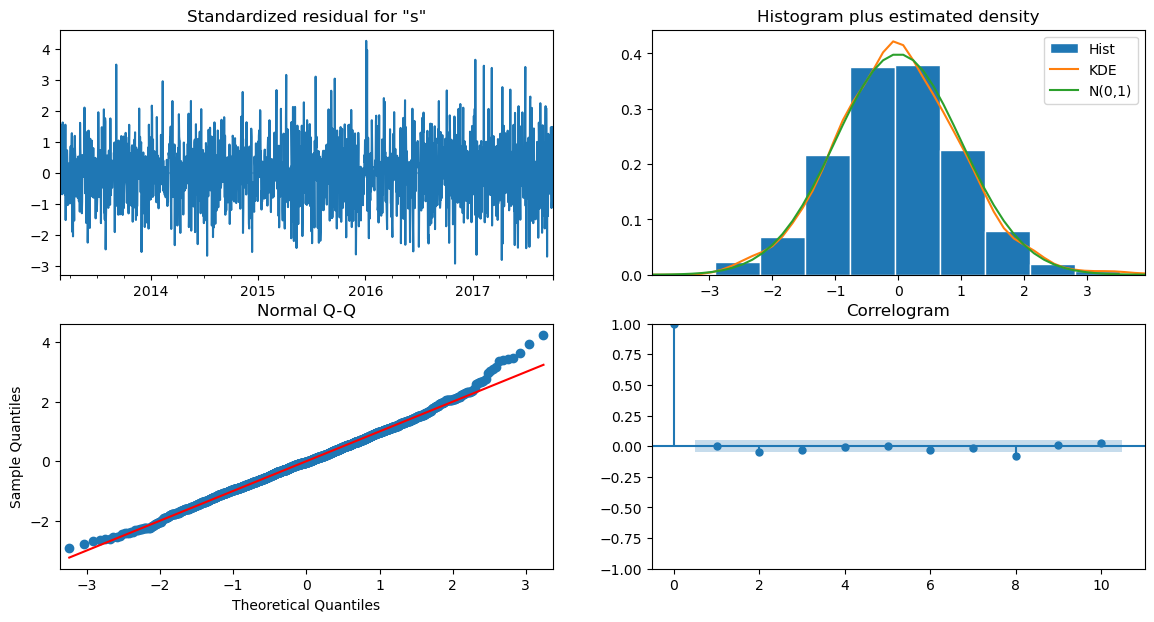

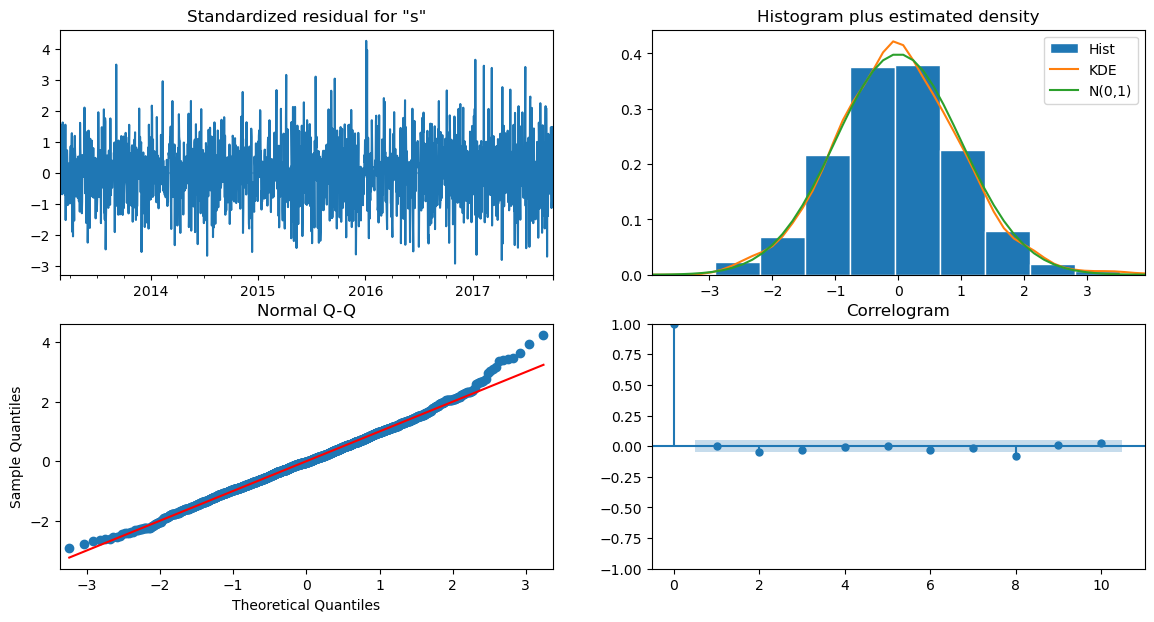

In [35]:
# fit the model
sarima_model = SARIMAX(arima_df.sales, order=(6, 1, 0), seasonal_order=(6, 1, 0, 7), 
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
arima_test_df['pred_sales'] = sarima_fit.predict(start=arima_test_df.index[0],
                                                 end=arima_test_df.index[-1], dynamic= True)
plot = sarima_fit.plot_diagnostics(figsize=(14,7))
plot

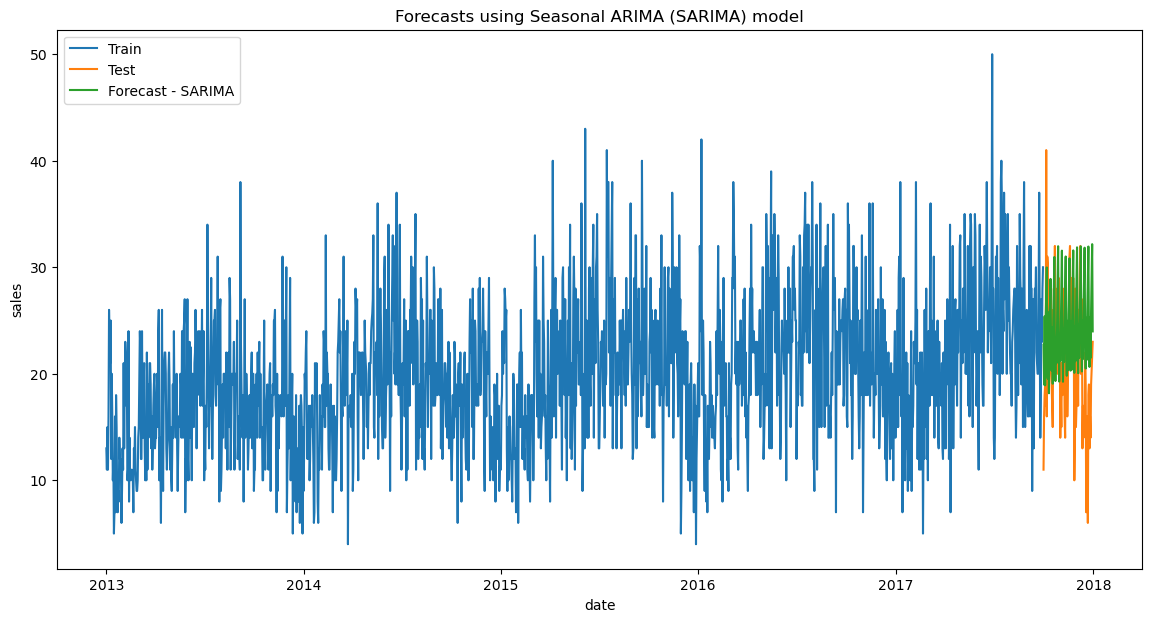

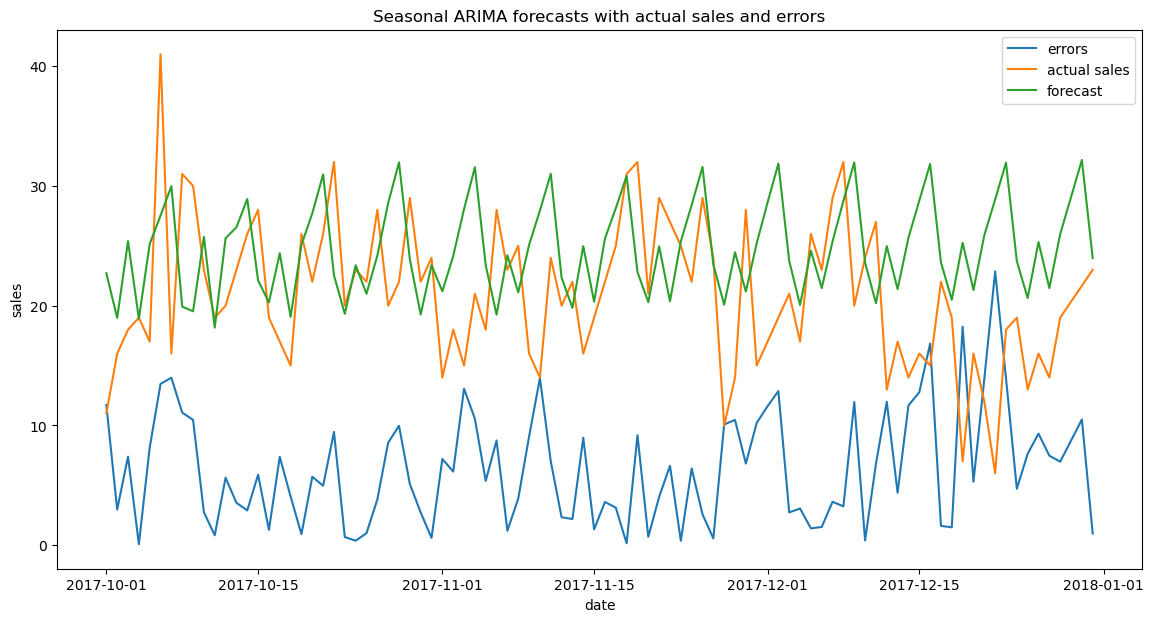

,total_sales,total_pred_sales,SARIMA_overall_error,MAE,RMSE,MAPE
model,,,,,,
SARIMA,1928.0,2270.012362,-342.012362,6.458555,8.023422,30.818833


In [36]:
# eval
arima_test_df['errors'] = arima_test_df.sales - arima_test_df.pred_sales
arima_test_df.insert(0, 'model', 'SARIMA')

# Evaluate the predictions for Seasonal ARIMA model
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='Test')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Seasonal ARIMA (SARIMA) model')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(arima_test_df.index, np.abs(arima_test_df['errors']), label='errors')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='actual sales')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal ARIMA forecasts with actual sales and errors')
plt.show()

result_df_sarima = arima_test_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          SARIMA_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_sarima

**Inference:** The ARIMA model with MAPE of 30.8% performed better than our baseline model.

Let's look at a Causal method: Regression, in order to forecast our sales data

## 4. Supervised Machine Learning: Linear Regression with additional features
Let's apply Linear Regression to our time series data in order to forecasts sales.

In [37]:
reg_df = df
reg_df

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13.000000,2013,1,1,1
31,2013-01-02,1,1,11.000000,2013,1,2,2
59,2013-01-03,1,1,15.000000,2013,1,3,3
90,2013-01-04,1,1,11.000000,2013,1,4,4
120,2013-01-05,1,1,16.000000,2013,1,5,5
...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14.000000,2017,12,27,2
1822,2017-12-28,1,1,19.000000,2017,12,28,3
1823,2017-12-29,1,1,20.333333,2017,12,29,4
1824,2017-12-30,1,1,21.666667,2017,12,30,5


### Step 1: Feature Engineering

In [38]:
# Lag features
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_df[lag_i] = reg_df.sales.shift(i)
    
# Rolling window
reg_df['rolling_mean'] = reg_df.sales.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.sales.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.sales.rolling(window=7).min()

reg_df = reg_df.dropna(how='any', inplace=False)
reg_df = reg_df.drop(['store', 'item'], axis=1)

# Split the series to predict the last 3 months of 2017
reg_df = reg_df.set_index('date')
reg_train_df = reg_df.loc[:'2017-09-30']                        
reg_test_df = reg_df.loc['2017-10-01':]

### Step 2: Feature Selection and Model Building

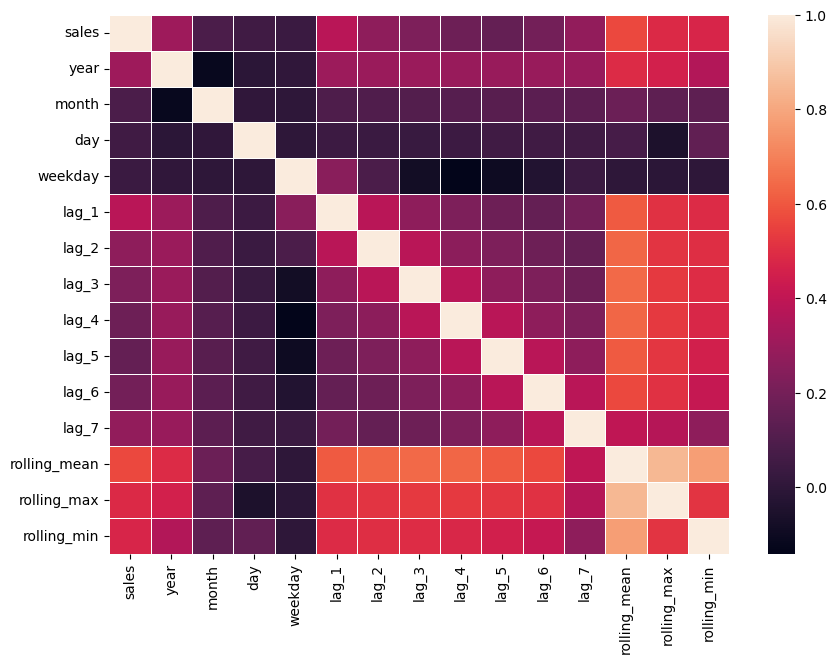

In [39]:
# Correlation matrix with heatmap
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
_ = sns.heatmap(corr, linewidths=.5)

In [40]:
X_train = reg_train_df.drop(['sales'], axis=1)
y_train = reg_train_df['sales'].values

X_test = reg_test_df.drop(['sales'], axis=1)
y_test = reg_test_df['sales'].values

#Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns
print(feature_scores.nlargest(5,'Score'))  # print 5 best features

         Feature       Score
11  rolling_mean  806.317368
12   rolling_max  526.787930
13   rolling_min  499.227690
4          lag_1  289.244557
0           year  176.597169


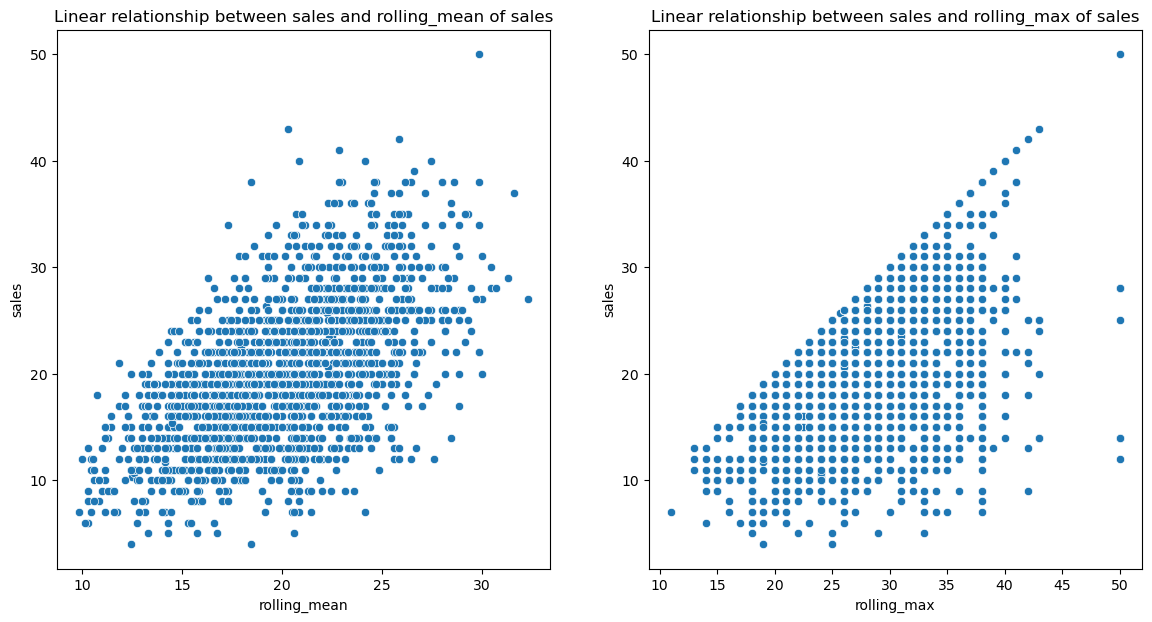

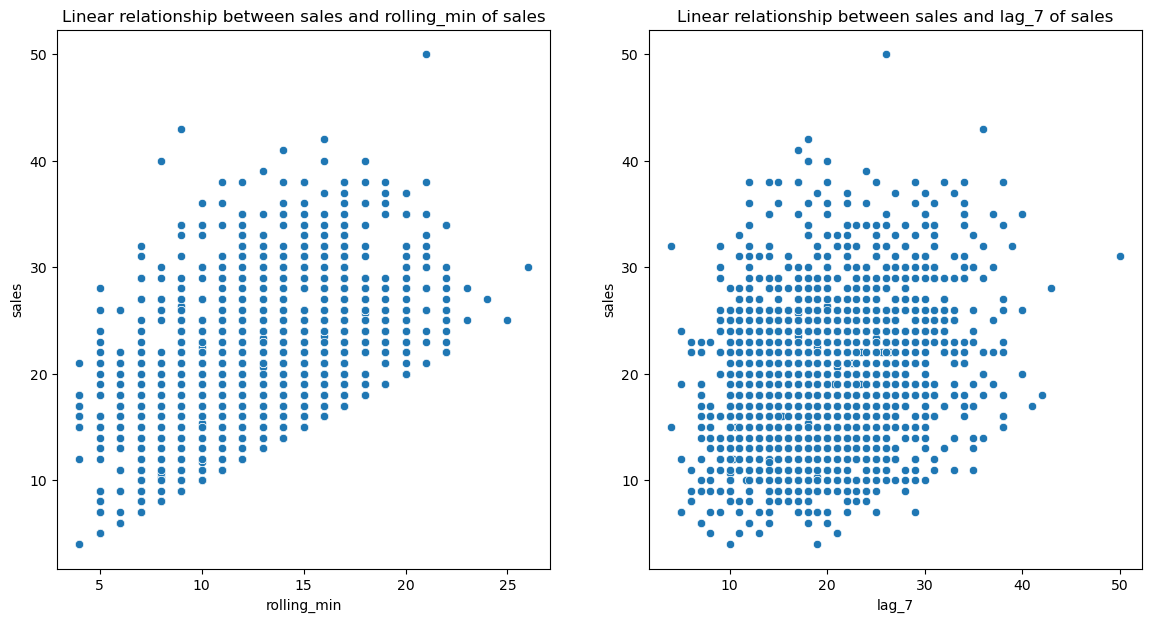

In [41]:
# Checking for a linear relationship of the top features with sales (target variable)

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sns.scatterplot(x=reg_train_df['rolling_mean'], y=reg_train_df['sales'], ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sns.scatterplot(x=reg_train_df['rolling_max'], y=reg_train_df['sales'], ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sns.scatterplot(x=reg_train_df['rolling_min'], y=reg_train_df['sales'], ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sns.scatterplot(x=reg_train_df['lag_7'], y=reg_train_df['sales'], ax=axs[1])
axs[1].set(title='Linear relationship between sales and lag_7 of sales')

plt.show()

In [42]:
# update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

errors_df = reg_test_df[['sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

### Step 3: Model Evaluation and Predictions

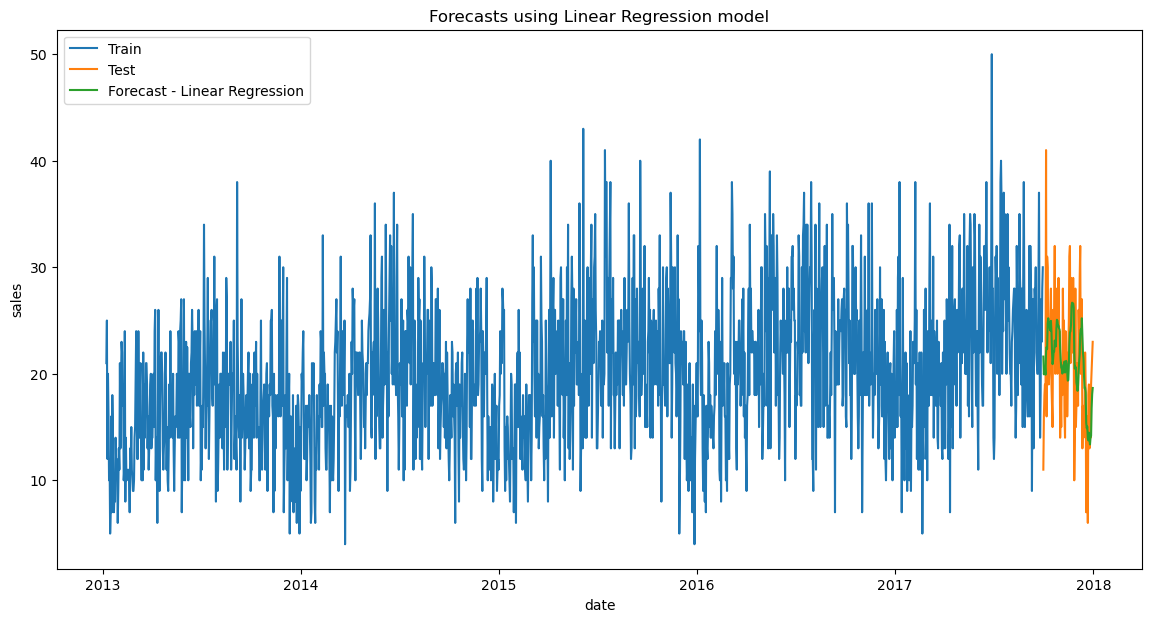

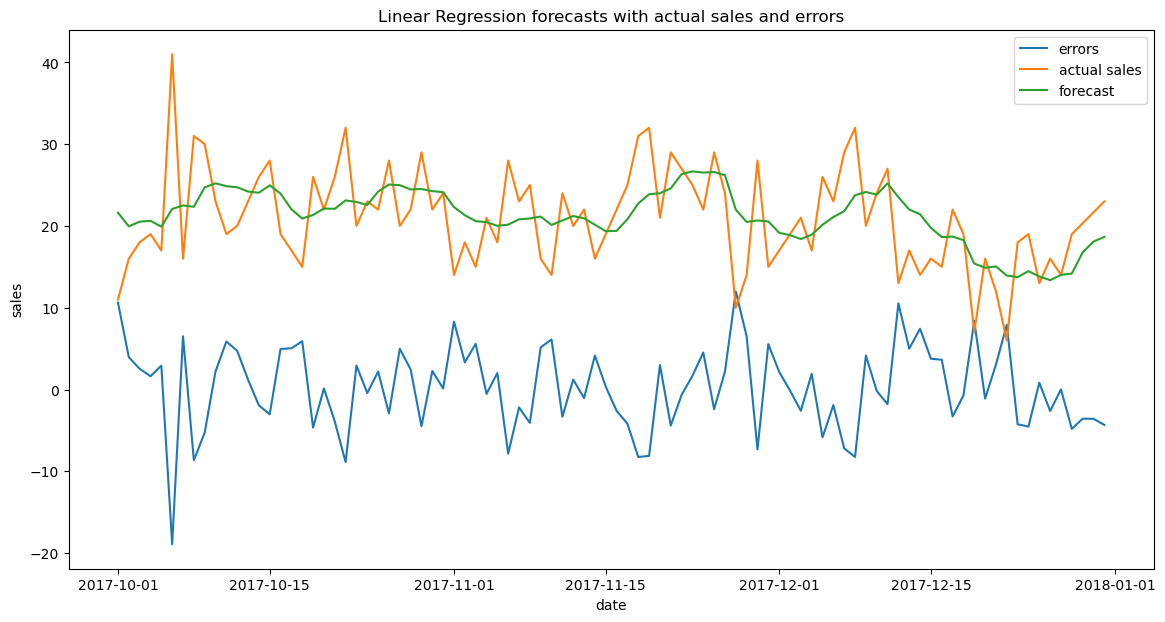

,total_sales,total_pred_sales,LR_overall_error,MAE,RMSE,MAPE
model,,,,,,
LinearRegression,1928.0,1950.771256,22.771256,4.178834,5.181288,19.940495


In [43]:
# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.sales, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

import numpy as np
result_df_lr = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr

**Inference:** The Linear regression model captures the upwards as well as the downwards movement in the sales data. Its performance, MAPE 19.9% , is better than our other models and which was the best performing model so far.

### Conclusion
We considered different time-series models as well as a regression model for time series forecasting. From our results we saw that the linear regression model outperformed the other time-series models. Therefore, for this dataset we could use a regression model, rather than a time-series model to forecast sales. One of the main assumptions of regression models is that the patterns in the historical data will be repeated in the future, and since our data was highly seasonal and had a linear trend, it made sense why the linear regression model out-performed the other models.